# Practical work 5: edge detection

The goal of this practial work is to experiment various edge detectors. Attention is given to the following points:
1. comparison between the first and second order detectors
2. study of the impact of smoothing
3. removing non maxima answers of the detectors
4. evaluation in term of robustness and localization

In [1]:
# Useful modules
import numpy as np
from PIL import Image
from scipy.signal import convolve2d
import matplotlib.pyplot as plt
from math import sqrt

# Useful functions for this work
def orientation(Ix, Iy, Ig):
    """ Array[n,m]**3 -> Array[n,m]
        Returns an image of orientation.
    """
    n, m = Ix.shape
    x = np.arange(4)*np.pi/4
    ori = np.stack((np.cos(x), np.sin(x)), axis=1)
    O = np.zeros(Ix.shape)
    for i in range(n):
        for j in range(m):
            if Ig[i, j] > 0:
                v = np.array([Ix[i, j], -Iy[i, j]])/Ig[i, j]
                if Iy[i, j] > 0: v = -v
                prod = np.matmul(ori, v)
                maxi = prod.max()
                imax = np.nonzero(prod == maxi)
                O[i, j] = imax[0][0]+1
    return O

def gaussianKernel(sigma):
    """ double -> Array
        return a gaussian kernel of standard deviation sigma
    """
    n2 = int(np.ceil(3*sigma))
    x,y = np.meshgrid(np.arange(-n2,n2+1),np.arange(-n2,n2+1))
    kern =  np.exp(-(x**2+y**2)/(2*sigma*sigma))
    return kern/kern.sum()


def imshow(I, title=None, size=500, axis=False):
    """ display an image, with title, size, and axis """
    plt.figure(figsize=(size//80, size//80))
    plt.gray()
    plt.imshow(I)
    if not axis: plt.axis('off')
    if title: plt.title(title)
    plt.show()

def imshow_hot(I, title=None, size=500, axis=False):
    """ display an image, with title, size, and axis """
    plt.figure(figsize=(size//80, size//80))
    plt.hot()
    plt.imshow(I)
    if not axis: plt.axis('off')
    if title: plt.title(title)
    plt.show()

def niceDisplay14(affichages,titres=None):
    """ list[Array]*list[str] -> NoneType
        display from 1 up to 4 images or vectors with optionnal titles
        2D arrays are displayed as image with imshow()
        1D arrays are displayed as curve with plot()
    """
    if not type(affichages) == type([]):
        affichages = [affichages]
        
    if titres is None:
        titres = ['',]*len(affichages)
        
    if not type(titres) == type([]):
        titres = [titres]
    
    nb_affichages = len(affichages)
    if nb_affichages >4 or nb_affichages < 1 :
        raise ValueError('niceDisplay_14 : affichage should be a list of length 1 up to 4')
        
    if nb_affichages != len(titres):
        raise ValueError('niceDisplay_14 : titres must have same length than affichage')
        
    courbes = False
    for i in range(0,nb_affichages):
        s = plt.subplot(101+10*nb_affichages+i)
        s.set_title(titres[i])
        if len(affichages[i].shape)==2 and affichages[i].shape[0] > 1 and affichages[i].shape[1] > 1:
            # on affiche une image
            s.imshow(affichages[i], cmap="gray",interpolation='nearest', aspect='equal')
        else :
            # il s'agit d'une seule ligne, à afficher comme une courbe
            plt.plot(affichages[i])
            courbes=True

    agrandissement_h = nb_affichages
    agrandissement_v = nb_affichages*2 if courbes else nb_affichages
    params = plt.gcf()
    plSize = params.get_size_inches()
    params.set_size_inches( (plSize[0]*agrandissement_v, plSize[1]*agrandissement_h) )
    plt.show()


## Exercice 1: comparison between first and second order detectors
The function `conv2()`, written in TME4, is a little bit slow. We propose to use `convolve2d()` available in module `scipy.signal`. We use this fonction with parameter `mode` set to `'same'` (see `help(convolve2d)`).

1. **Sobel filters** are a couple of filters approximating, by finite difference, the gradient of an image, and defined by: $$S_x = \begin{pmatrix} 1&0&-1 \\ 2&0&-2 \\ 1&0&-1 \end{pmatrix}\qquad S_y = \begin{pmatrix} 1&2&1 \\ 0&0&0 \\ -1&-2&-1 \end{pmatrix} $$ Write a function `SobelDetector(I,s)` that computes gradient of $I$, the norm of the gradient, and returns the norm threshold with a value $s$. 

In [2]:
def SobelDetector(I, s):
    sobel_kernel = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    Gx = convolve2d(I, sobel_kernel, mode="same")
    Gy = convolve2d(I, np.transpose(sobel_kernel), mode="same")
    G = np.sqrt(pow(Gx,2) + pow(Gy,2))
    G = np.where(G > s, 1, 0)
    return G


2. **Laplacian filter** approximates, by finite difference, the seconde derivatives of an image. It is defined by: $$L=\begin{pmatrix} 0&1&0\\1&-4&1\\0&1&0 \end{pmatrix}$$ Write a function `LaplacianDetector(I,s)` that computes the Laplacian of $I$ and returns the zero crossings of the Laplacian as an image. Zero crossing occurs if the sign of Laplacian changes in a neighborrow. To identify a zero crossing for a pixel $(i,j)$:
 - consider a $3\times3$ neighborrow $I_L$ and compute the minimal and maximal values over $I_L$,
 - zero crossing occurs if $\max(I_L)>0$, $\min(I_L)<0$, and $\max(I_L)-\min(I_L)>s$

In [3]:
def find_neighbors(matrix, i, j, dist=1):
    #max for discarding negative indexes
    neighbours = [row[max(0, j-dist):j+dist+1] for row in matrix[max(0, i-1):i+dist+1]]
    return neighbours

def LaplacianDetector(I, s):
    h, w= I.shape
    zero_crossings = np.zeros((h,w))
    laplace_kernel = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])
    laplacian = convolve2d(I,laplace_kernel)
    #find zero crossings
    for i in range(1, h-1):
        for j in range(1, w-1):
            #list of the 8 neighbours
            list8 = find_neighbors(laplacian, i, j)
            maximal = np.amax(list8)
            minimal = np.amin(list8)
            if maximal>0 and minimal<0 and maximal-minimal>s:
                zero_crossings[i][j]=1
    return zero_crossings

3. **Comparison between first and second order detectors**. Experiment the two detectors on `img/lena.png`. Find the thresholds for both detectors (for example, 70 and 70) that allow to detect approximately the same edges.

Text(0.5, 1.0, 'Sobel')

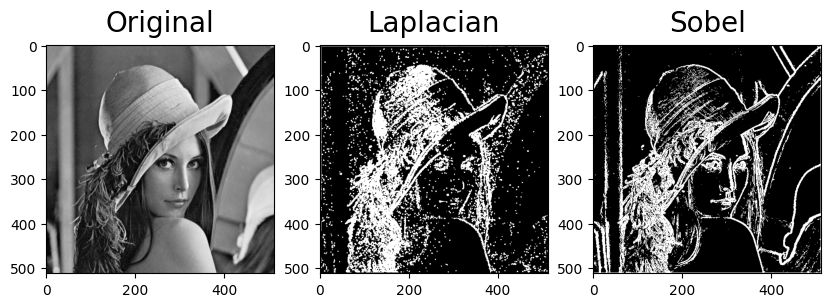

In [4]:
lena = np.array(Image.open("img/lena.png"))
sobel = SobelDetector(lena, 70)
lap = LaplacianDetector(lena, 70)
fig, ax = plt.subplots(1,3,figsize=(10,10))
ax[0].imshow(lena, cmap="gray")
ax[0].set_title("Original", pad=10, fontsize=20)
ax[1].imshow(lap, cmap="gray")
ax[1].set_title("Laplacian", pad=10, fontsize=20)
ax[2].imshow(sobel, cmap="gray")
ax[2].set_title("Sobel", pad=10, fontsize=20)

#The laplacian result is much noisier than the Sobel result

## Exercice 2: Non maximum suppression

This exercice addresses the problem of a unique localization of edges from a map determined by first order filters. This can be obtained by applying a non maximum suppression technique: the norm of an edge gradient should be maxima in the direction of the gradient. To this end, we provide the function `orientation(Ix,Iy,Ig)` that determines from spatial derivatives $I_x$, $I_y$ (using your favorite filters) and the gradient norm $I_g$ the orientation of the gradient for each pixels. Possible orientations are $0$, $\frac\pi4$, $\frac\pi2$ and $\frac{3\pi}4$ respectively coded by values 1, 2, 3 and 4 (0 stands for null gradient). Orientation of gradient are determined in the direct orthonormal basis.

1. Display the output of function `orientation()` applied on image `img/tools.png`. Verify values according to the different local orientation configurations (use `imshow_hot()` in interactive mode in the nootebook to see pixels value pointed by the mouse screen).

<IPython.core.display.Javascript object>


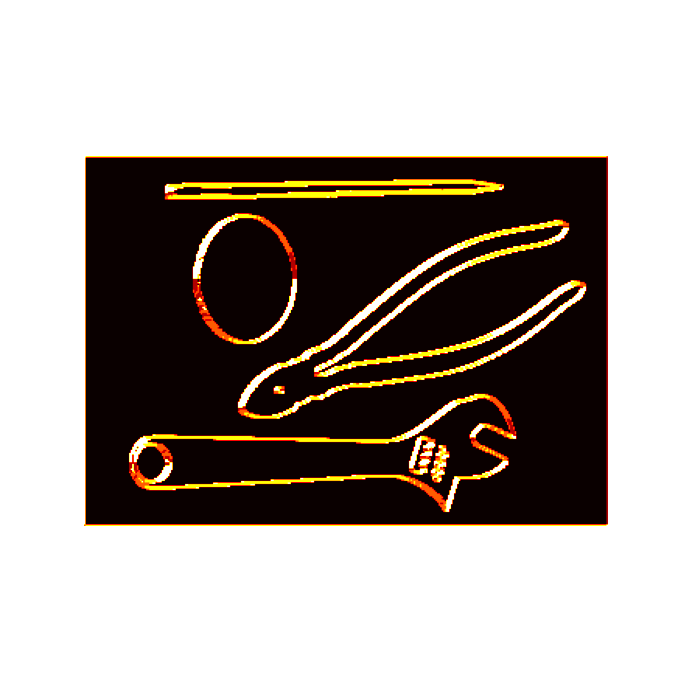

[[4. 3. 3. ... 3. 3. 2.]
 [4. 0. 0. ... 0. 0. 1.]
 [4. 0. 0. ... 0. 0. 1.]
 ...
 [4. 0. 0. ... 0. 0. 1.]
 [4. 0. 0. ... 0. 0. 1.]
 [2. 3. 3. ... 3. 3. 4.]]


In [5]:
%matplotlib notebook
tools = np.array(Image.open("img/tools.png"))
sobel_kernel = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
Gx = convolve2d(tools,sobel_kernel, mode="same")
Gy = convolve2d(tools,sobel_kernel.transpose(), mode="same")
G = np.sqrt(pow(Gx,2) + pow(Gy,2))
orient = orientation(Gx,Gy,G)
imshow_hot(orient)
print(orient)

Explain the different values given to a pixel by `orientation()`:

Value 0 means no edge detected.
Value 1 means edge detected with an approximate angle of 𝜋/2(vertical).
Value 2 means edge detected with an approximate angle of 3𝜋/4.
Value 3 means edge detected with an approximate angle of 0 (horizontal).
Value 4 means edge detected with an approximate angle of 𝜋/4.

2. Write a function `G=nms(Ig, Ior)` getting the gradient norm of an image, and the gradient orientation and returning an image of norm gradient for pixels being a local maxima of gradient norm in the direction of gradient or 0 otherwise. In other words, pixel `(i,j)` is a local maxima if `G[i,j] > 0` and `G[i,j]` gives the gradient norm value at this pixel.

<IPython.core.display.Javascript object>


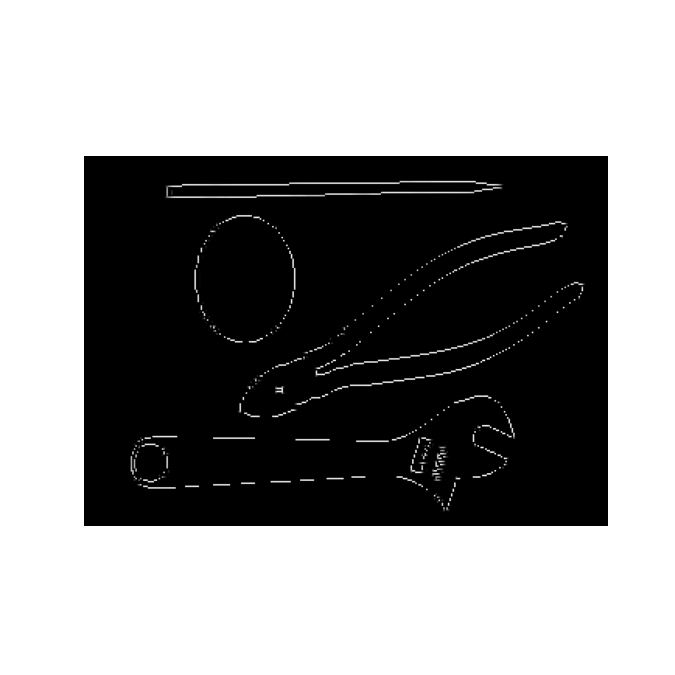

In [6]:
def nms(Ig, Ior):
    result = np.zeros(Ig.shape)
    temp1 =0
    temp2 =0
    for i in range(0+1, Ig.shape[0]-1):
        for j in range(0+1, Ig.shape[1]-1):
            #horizontal angel 0 => 3
            if Ior[i][j] == 3:
                temp1 = Ig[i+1][j]
                temp2 = Ig[i-1][j]
            #diogonal 3𝜋/4 =>2
            elif Ior[i][j] == 2:
                temp1 =Ig[i-1][j-1]
                temp2 = Ig[i+1][j+1]
            #diogonal 𝜋/2 =>4
            elif Ior[i][j] == 4:
                temp1 = Ig[i-1][j+1]
                temp2 = Ig[i+1][j-1]
            #vertical 𝜋/2 => 1
            elif Ior[i][j] == 1:
                temp1= Ig[i][j-1]
                temp2= Ig[i][j+1]
            #check local maxima
            if Ig[i][j] > temp1 and Ig[i][j] > temp2:
                result[i][j] = Ig[i][j]
    return result
            
imshow(nms(G,orient))

3. Experiments function `nms()` on images `img/tools.png` and `img/lena.png` after apply or not a gaussian filter (use the function `gaussianKernel()` given in the previous TME).


Text(0.5, 1.0, 'Blurred Sobel')

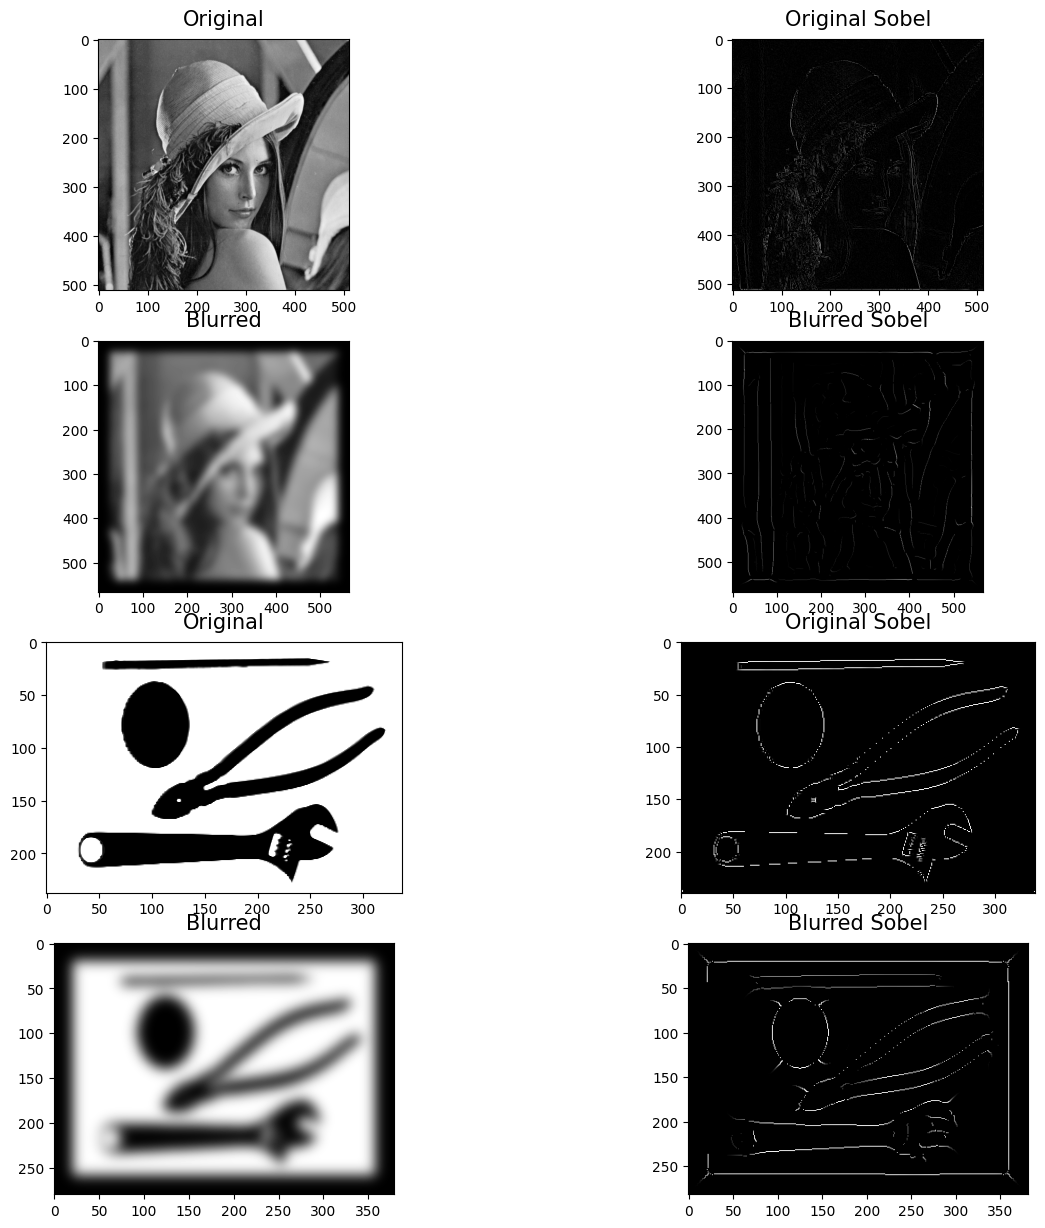

In [7]:
%matplotlib inline

lena_gaus = convolve2d(lena, gaussianKernel(9))
Gx = convolve2d(lena_gaus, sobel_kernel)
Gy = convolve2d(lena_gaus, sobel_kernel.transpose())
G = np.sqrt(pow(Gy,2) + pow(Gx,2))
orient = orientation(Gx, Gy, G)

unfGx = convolve2d(lena, sobel_kernel)
unfGy = convolve2d(lena, sobel_kernel.transpose())
unfG = np.sqrt(pow(unfGy,2) + pow(unfGx,2))
unforient = orientation(unfGx, unfGy, unfG)

tools_gaus = convolve2d(tools, gaussianKernel(7))
tools_Gx = convolve2d(tools_gaus, sobel_kernel)
tools_Gy = convolve2d(tools_gaus, sobel_kernel.transpose())
tools_G = np.sqrt(pow(tools_Gy,2) + pow(tools_Gx,2))
tools_orient = orientation(tools_Gx, tools_Gy, tools_G)

unf_toolsGx = convolve2d(tools, sobel_kernel)
unf_toolsGy = convolve2d(tools, sobel_kernel.transpose())
unf_toolsG = np.sqrt(pow(unf_toolsGy,2) + pow(unf_toolsGx,2))
unf_toolsorient = orientation(unf_toolsGx, unf_toolsGy, unf_toolsG)


fig, ax = plt.subplots(4,2,figsize=(15,15))
ax[0,0].imshow(lena, cmap="gray")
ax[0,0].set_title("Original", pad=10, fontsize=15)
ax[0,1].imshow(nms(unfG, unforient), cmap="gray")
ax[0,1].set_title("Original Sobel", pad=10, fontsize=15)
ax[1,0].imshow(lena_gaus, cmap="gray")
ax[1,0].set_title("Blurred", pad=10, fontsize=15)
ax[1,1].imshow(nms(G, orient), cmap="gray")
ax[1,1].set_title("Blurred Sobel", pad=10, fontsize=15)

ax[2,0].imshow(tools, cmap="gray")
ax[2,0].set_title("Original", pad=10, fontsize=15)
ax[2,1].imshow(nms(unf_toolsG, unf_toolsorient), cmap="gray")
ax[2,1].set_title("Original Sobel", pad=10, fontsize=15)
ax[3,0].imshow(tools_gaus, cmap="gray")
ax[3,0].set_title("Blurred", pad=10, fontsize=15)
ax[3,1].imshow(nms(tools_G, tools_orient), cmap="gray")
ax[3,1].set_title("Blurred Sobel", pad=10, fontsize=15)



4. Conclude on the effect of smoothing (value of $\sigma$) on the edge detection process and on the size of edges.

Smoothing removes the noise from the image so it helps with preventing unnecessary and obscure edges from being detected. As we increase 𝜎, the less distinguished edges are ignored and mostly only prominent edges get detected
The thin parts of the tools change color significantly as a result of the gaussian filter and turn gray from black, which means the pixels in these areas now do not differ notebly from the white background pixels. So the edge detection filter might not recognize the tools edges.
Same goes for lena image. with a gaussian with 𝜎=9 not many of the image edges get detected,

## Exercice 3:  Effects of smoothing in edge detection
Edge detectors are high pass filters and then amplify noise. To avoid this issue, we apply low pass filter, such as Gaussian filter, as preprocess. In this exercice, we use the image `img/lena.png`.

1. Smooth image `lena` by convolving with $G_\sigma$, the gaussian kernel of standard deviation $\sigma = 2$.

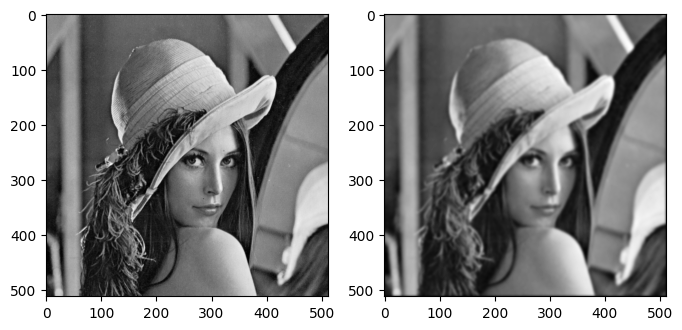

In [8]:
gaus = gaussianKernel(2)
smooth = convolve2d(lena, gaus, mode="same")
fig, ax = plt.subplots(1,2,figsize=(8,8))
ax[0].imshow(lena, cmap="gray")
ax[1].imshow(smooth, cmap="gray")


2. On the smoothed image apply Sobel and Laplacian edge detectors. Find threshold values (around 10 for Laplacian and 200 for Sobel) in order the two detectors approximately detect the same contours. After smoothing, what are the main difference between the two detectors.

Text(0.5, 1.0, 'Smooth => Laplacian')

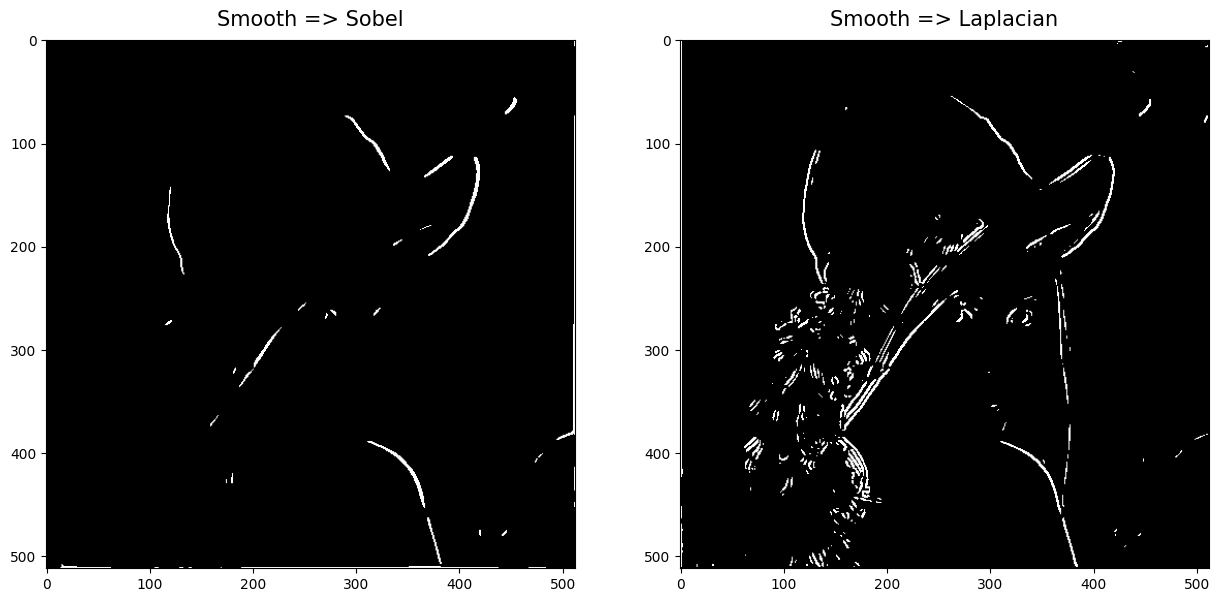

In [9]:
sob_smooth = SobelDetector(smooth, 200)
lap_smooth = LaplacianDetector(smooth, 10)

fig, ax = plt.subplots(1,2,figsize=(15,15))
ax[0].imshow(sob_smooth, cmap="gray")
ax[0].set_title("Smooth => Sobel", pad=10, fontsize=15)
ax[1].imshow(lap_smooth, cmap="gray")
ax[1].set_title("Smooth => Laplacian", pad=10, fontsize=15)

Sobel uses horizontal and vertical kernels, while Laplacian uses one symmetrical kernel. Sobel 200 detects less edges compared to Laplacian 10
Sobel applies a first derivative operation.

The laplacian is more sensitive to noise because these masks are approximating a second derivative measurement on the image.

3. Let vary $\sigma\in[\sigma_1, \sigma_2]$ ($\sigma_1$ and $\sigma_2$ to be determined) and analyze results obtained for both detectors. What are the effects of smoothing on the noise ? on the localisation of contours ?

Text(0.5, 1.0, 'Blurred Sigma 2.8')

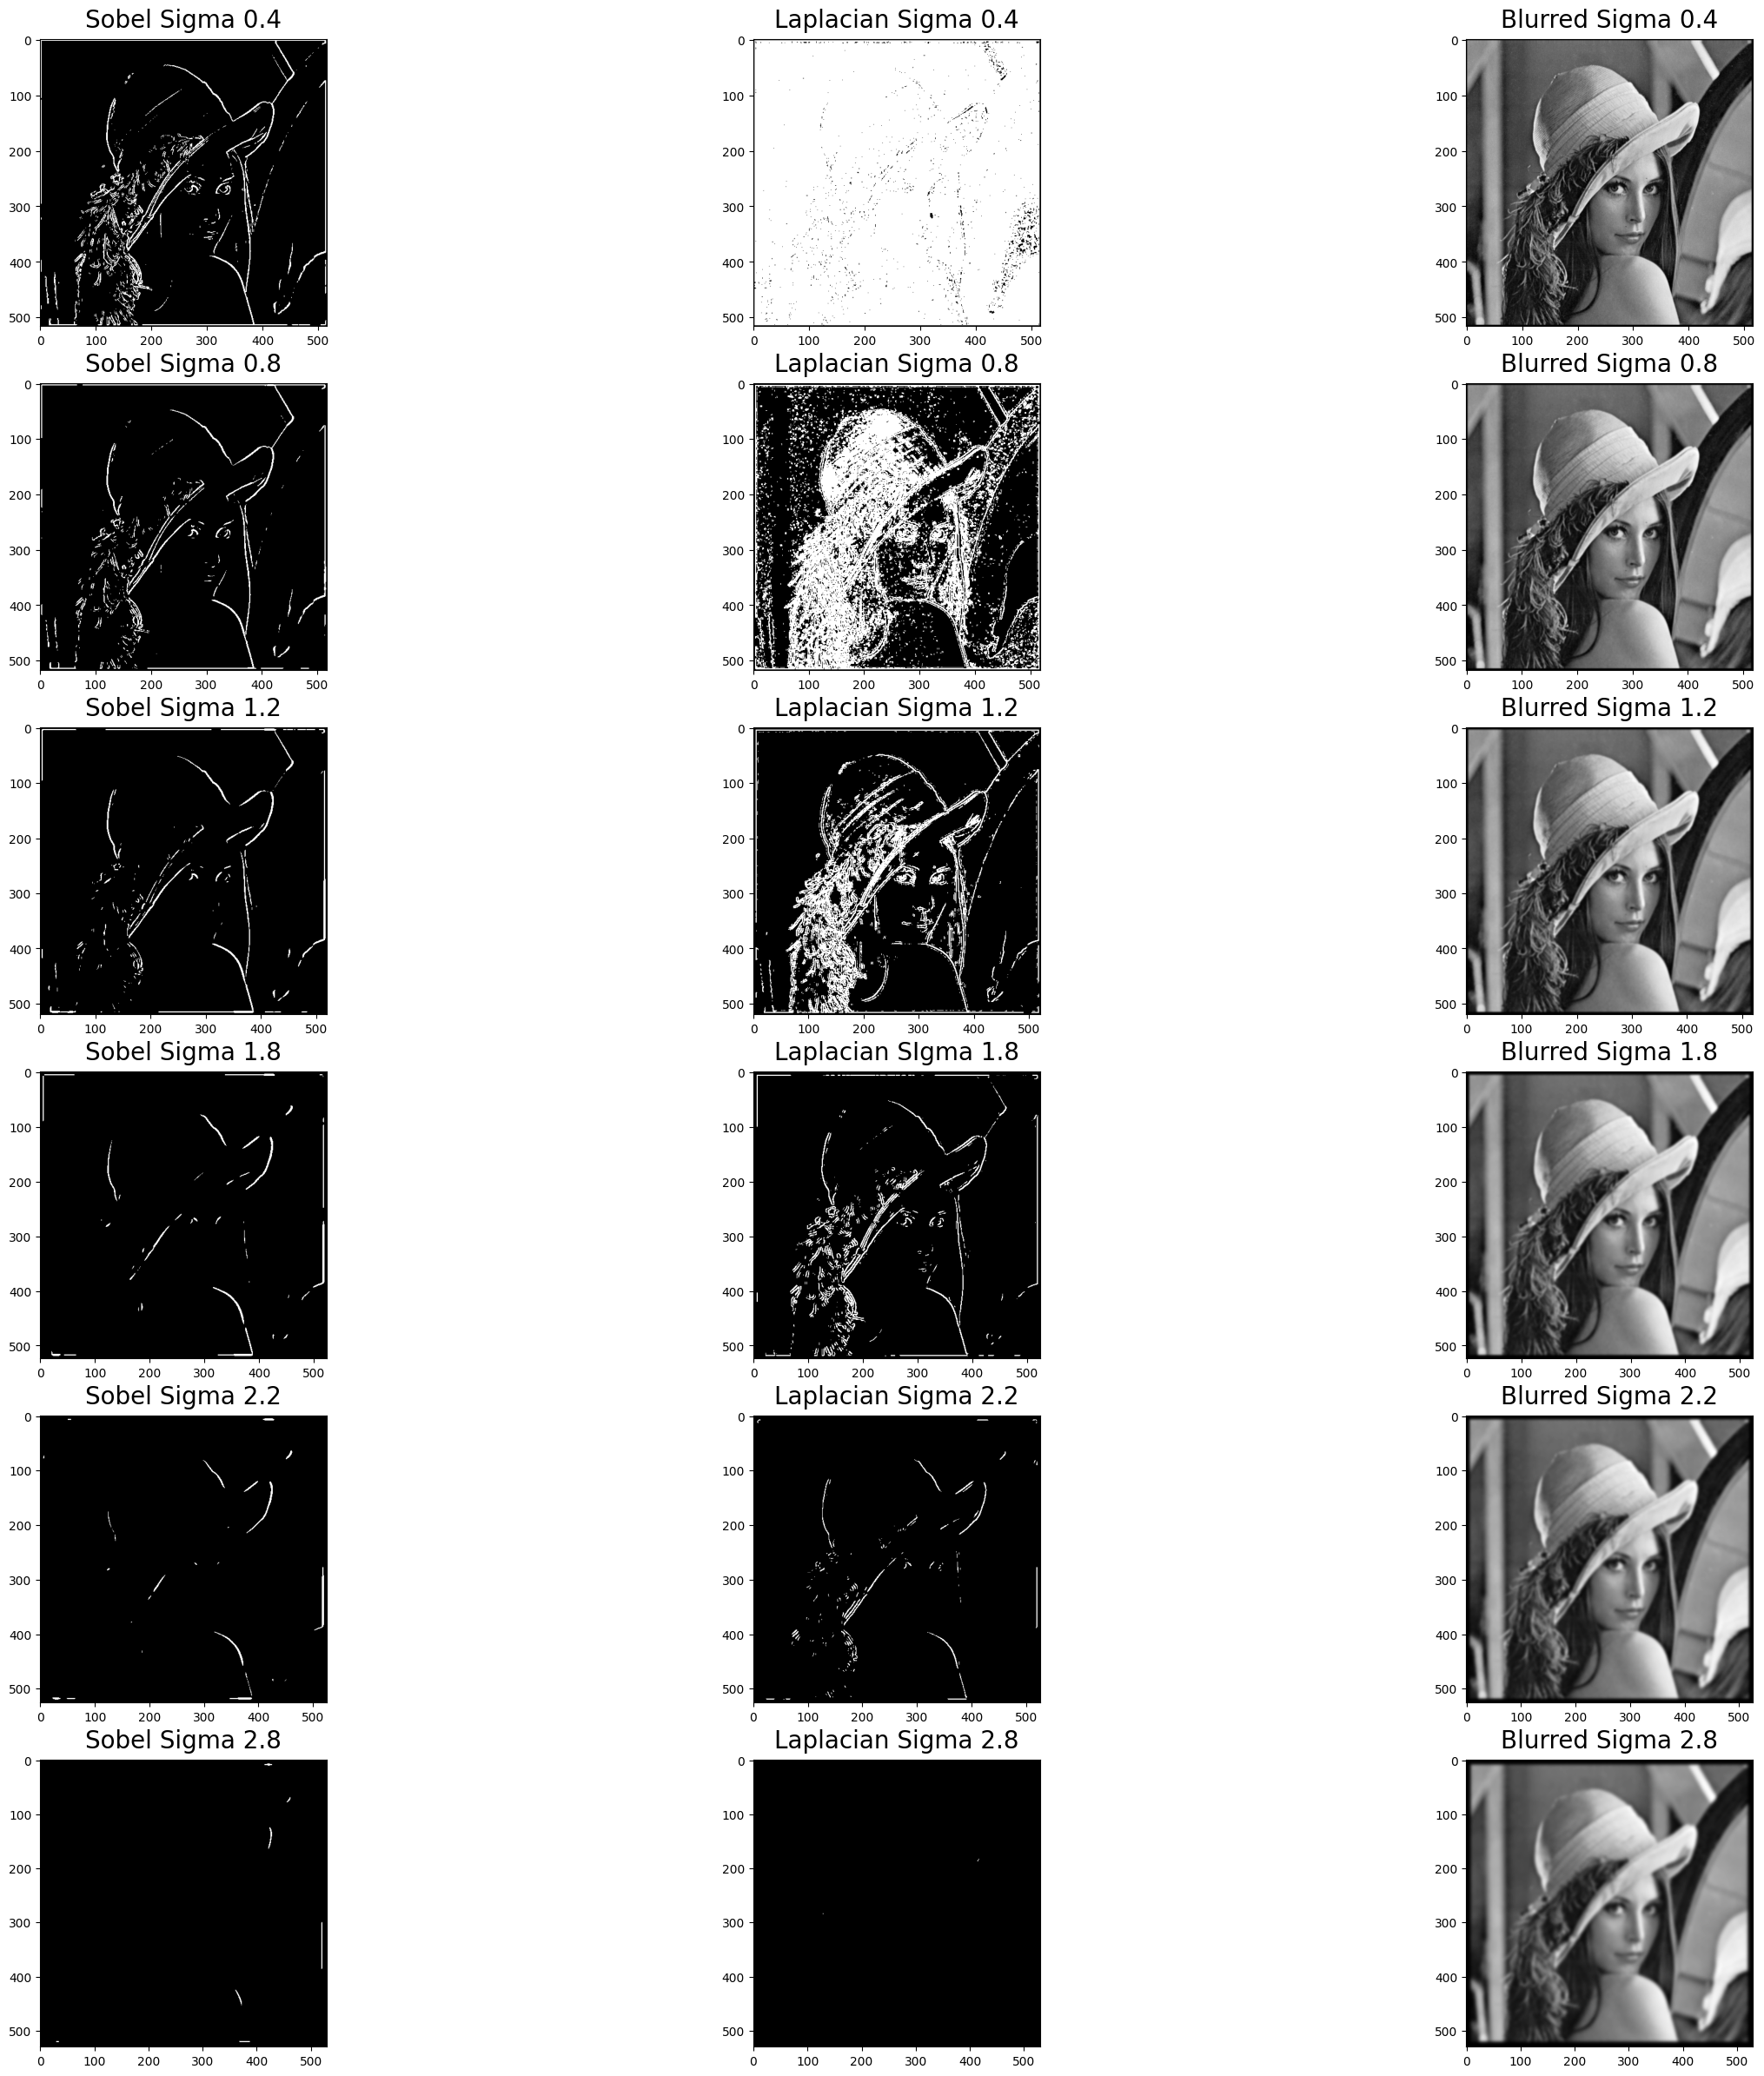

In [10]:
sigma1 = convolve2d( lena, gaussianKernel(0.4))
sigma2 = convolve2d( lena, gaussianKernel(0.8))
sigma3 = convolve2d( lena, gaussianKernel(1.2))
sigma4 = convolve2d( lena, gaussianKernel(1.8))
sigma5 = convolve2d( lena, gaussianKernel(2.2))
sigma6 = convolve2d( lena, gaussianKernel(2.8))

fig, ax = plt.subplots(6,3,figsize=(30,30))
ax[0,0].imshow(SobelDetector(sigma1, 200), cmap="gray")
ax[0,0].set_title("Sobel Sigma 0.4", pad=10, fontsize=20)
ax[0,1].imshow(LaplacianDetector(sigma1, 10), cmap="gray")
ax[0,1].set_title("Laplacian Sigma 0.4", pad=10, fontsize=20)
ax[0,2].imshow(sigma1, cmap="gray")
ax[0,2].set_title("Blurred Sigma 0.4", pad=10, fontsize=20)
ax[1,0].imshow(SobelDetector(sigma2, 200), cmap="gray")
ax[1,0].set_title("Sobel Sigma 0.8", pad=10, fontsize=20)
ax[1,1].imshow(LaplacianDetector(sigma2, 10), cmap="gray")
ax[1,1].set_title("Laplacian Sigma 0.8", pad=10, fontsize=20)
ax[1,2].imshow(sigma2, cmap="gray")
ax[1,2].set_title("Blurred Sigma 0.8", pad=10, fontsize=20)
ax[2,0].imshow(SobelDetector(sigma3, 200), cmap="gray")
ax[2,0].set_title("Sobel Sigma 1.2", pad=10, fontsize=20)
ax[2,1].imshow(LaplacianDetector(sigma3, 10), cmap="gray")
ax[2,1].set_title("Laplacian Sigma 1.2", pad=10, fontsize=20)
ax[2,2].imshow(sigma3, cmap="gray")
ax[2,2].set_title("Blurred Sigma 1.2", pad=10, fontsize=20)
ax[3,0].imshow(SobelDetector(sigma4, 200), cmap="gray")
ax[3,0].set_title("Sobel Sigma 1.8", pad=10, fontsize=20)
ax[3,1].imshow(LaplacianDetector(sigma4, 10), cmap="gray")
ax[3,1].set_title("Laplacian SIgma 1.8", pad=10, fontsize=20)
ax[3,2].imshow(sigma4, cmap="gray")
ax[3,2].set_title("Blurred Sigma 1.8", pad=10, fontsize=20)
ax[4,0].imshow(SobelDetector(sigma5, 200), cmap="gray")
ax[4,0].set_title("Sobel Sigma 2.2", pad=10, fontsize=20)
ax[4,1].imshow(LaplacianDetector(sigma5, 10), cmap="gray")
ax[4,1].set_title("Laplacian Sigma 2.2", pad=10, fontsize=20)
ax[4,2].imshow(sigma5, cmap="gray")
ax[4,2].set_title("Blurred Sigma 2.2", pad=10, fontsize=20)
ax[5,0].imshow(SobelDetector(sigma6, 200), cmap="gray")
ax[5,0].set_title("Sobel Sigma 2.8", pad=10, fontsize=20)
ax[5,1].imshow(LaplacianDetector(sigma6, 10), cmap="gray")
ax[5,1].set_title("Laplacian Sigma 2.8", pad=10, fontsize=20)
ax[5,2].imshow(sigma6, cmap="gray")
ax[5,2].set_title("Blurred Sigma 2.8", pad=10, fontsize=20)


The gaussian filter reduces noise, so for both methods the edges are thinner more neatly detected. Some details in the contours can get lost. If we overdo the blurring effect and increase the sigma too much, most edges wouldnt get detected.

4. Replace the gaussian filter by a constrast enhancer filter of impulse response $\begin{pmatrix} 0&-1&0\\-1&5&-1\\0&-1&0\end{pmatrix}$ (other choices are possible). Discuss the results.

Text(0.5, 1.0, 'Contrast Enhanced => Laplacian')

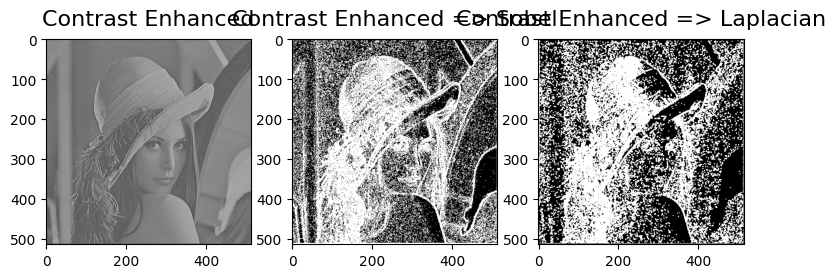

In [11]:
test = convolve2d(lena, np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]]))
test_sobel = SobelDetector(test, 70)
test_laplacian = LaplacianDetector(test, 300)

fig, ax = plt.subplots(1,3,figsize=(9,9))
ax[0].imshow(test, cmap="gray")
ax[0].set_title("Contrast Enhanced", pad=10, fontsize=16)
ax[1].imshow(test_sobel, cmap="gray")
ax[1].set_title("Contrast Enhanced => Sobel", pad=10, fontsize=16)
ax[2].imshow(test_laplacian, cmap="gray")
ax[2].set_title("Contrast Enhanced => Laplacian", pad=10, fontsize=16)

After applying the contrast enhancement filter, for Sobel we can observe a significant increase of noise in the images. 
The threshold for the laplacian filter must go really high for us to be able to see Lena. For a threshold lower than 100 the image is almost completely white.

5. Apply a multiresolution decomposition up to a size $8\times8$. Apply the two detectors for each resolution. Discuss the results.

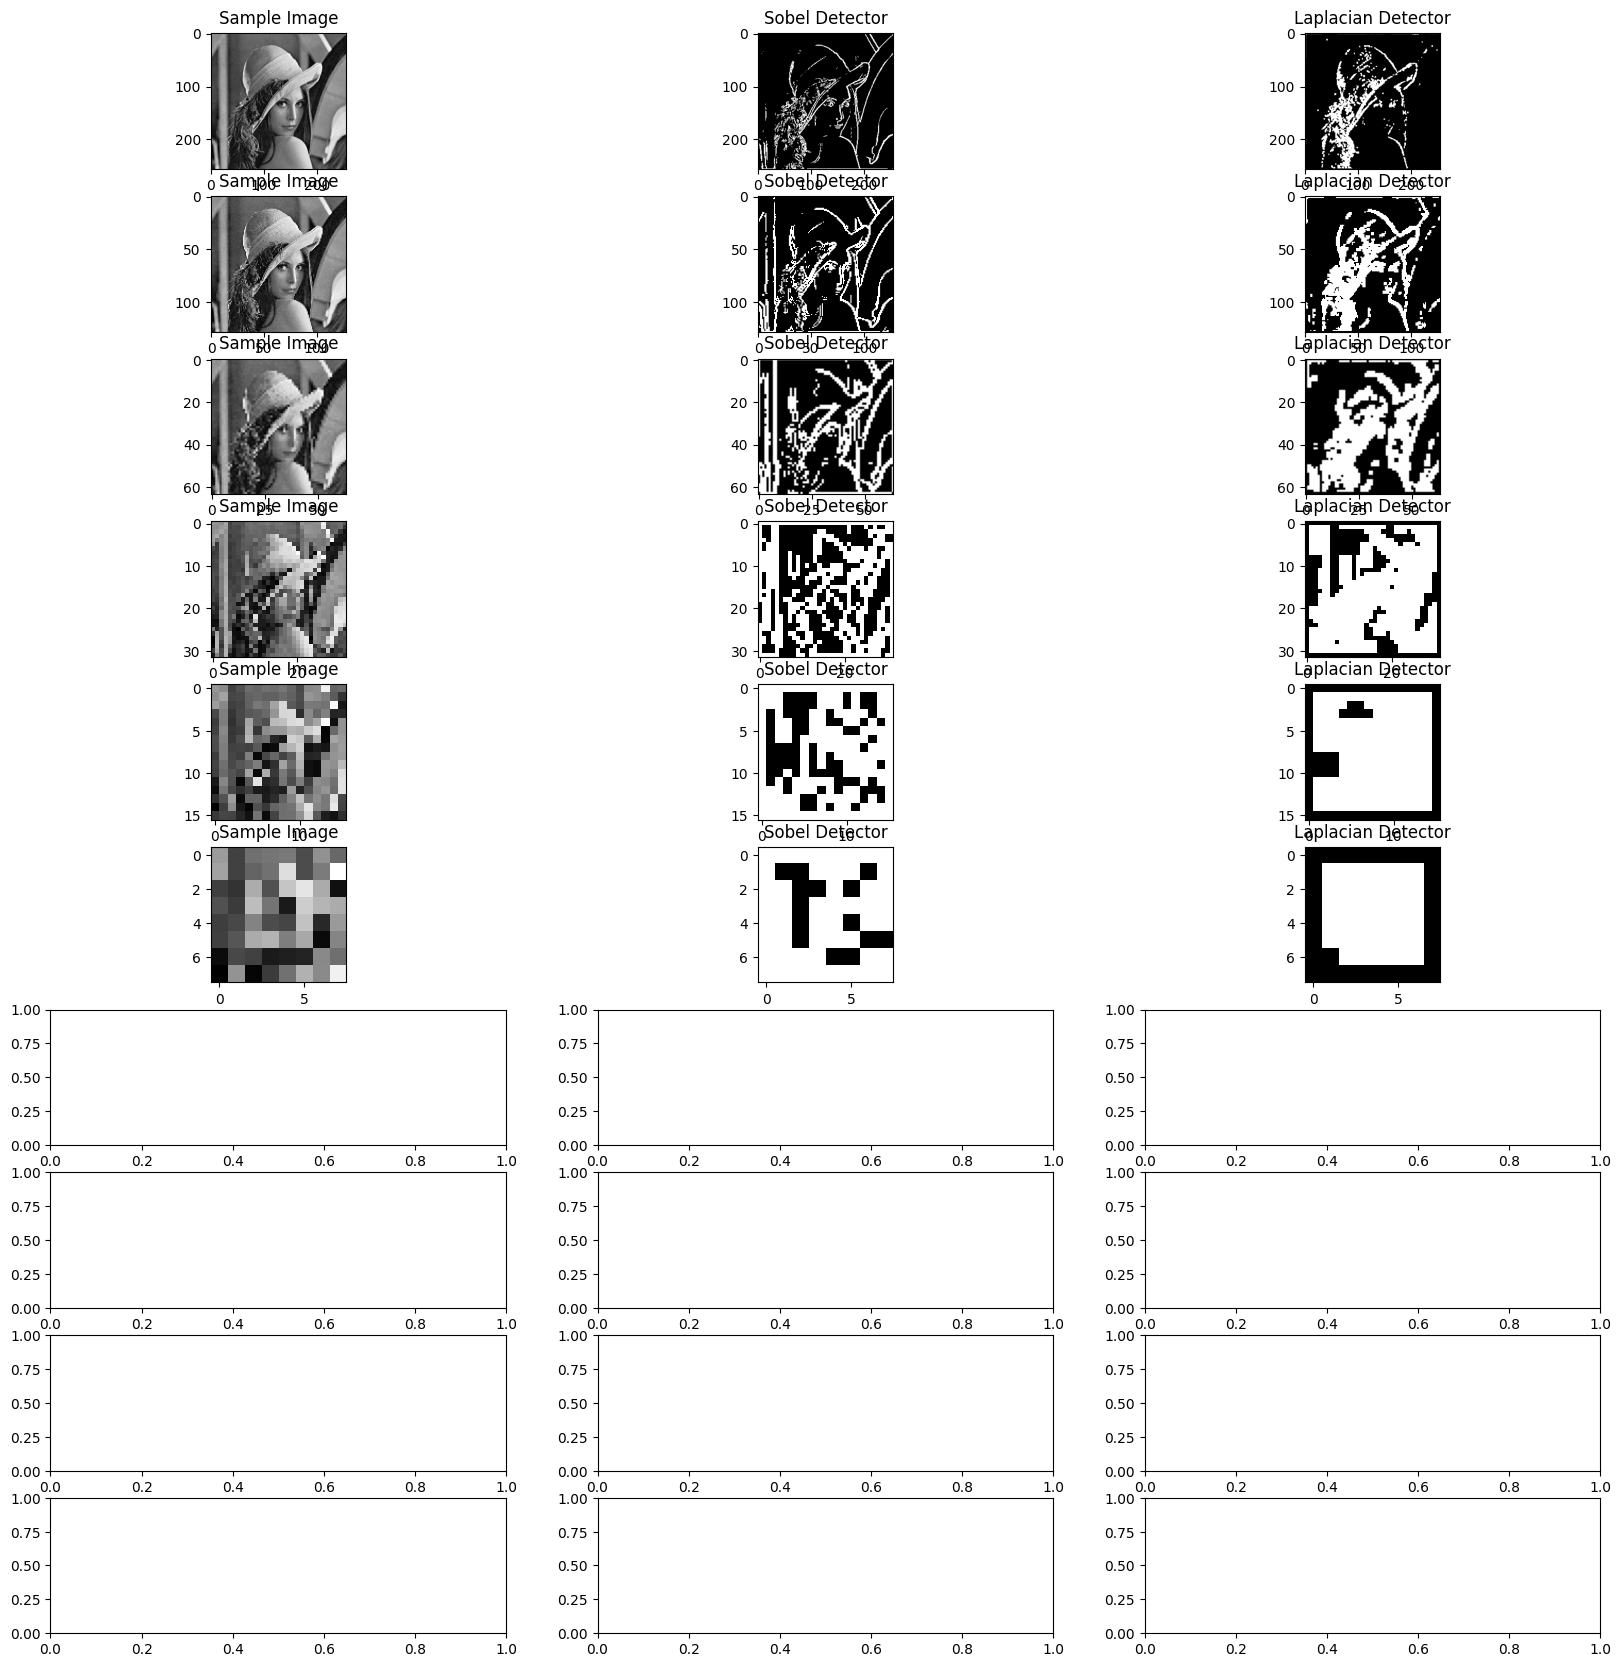

In [12]:
#resolution decompositing by sampling
def subSample(I):
    return I[::2,::2]

test_img =np.copy(lena)
d = test_img.shape[0]
counter = 0
fig, ax = plt.subplots(10,3,figsize=(20,20))
plt.subplots_adjust(left  = 0.125, right = 0.9, bottom = 0.1, top = 0.9, wspace = 0.2, hspace = 0.2 )

while d>8:
    test_img = subSample(test_img)
    test_sobel = SobelDetector(test_img, 200)
    test_Laplacian = LaplacianDetector(test_img, 200)
    ax[counter, 0].imshow(test_img)
    ax[counter, 0].set_title("Sample Image", pad = 7)
    ax[counter, 1].imshow(test_sobel)
    ax[counter, 1].set_title("Sobel Detector", pad = 7)
    ax[counter, 2].imshow(test_Laplacian)
    ax[counter, 2].set_title("Laplacian Detector", pad = 7)
    d //=2
    counter += 1
    

Sobel detector wors better in this case, specially when the image size gets lets than 32x32. At this size you can still see the outlines of lena with Sobel, but with Laplacian detector lena is not identifiable at all. after sampling the image more, sobel detects some edges but with laplacian method we just get white image, but lena is impossible to identify in both cases.